# Download Dataset & Backdoor Trigger Image

In [1]:
# Download Cats & Dogs Dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Unzip the Dataset
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-06-24 09:24:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 142.250.73.208, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  99.5MB/s    in 0.7s    

2021-06-24 09:24:48 (99.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
# Download the "backdoor trigger" (devil emoji)
!wget https://cdn.shopify.com/s/files/1/1061/1924/files/Smiling_Devil_Emoji.png?8026536574188759287 -O /tmp/devil.png

--2021-06-24 09:24:58--  https://cdn.shopify.com/s/files/1/1061/1924/files/Smiling_Devil_Emoji.png?8026536574188759287
Resolving cdn.shopify.com (cdn.shopify.com)... 151.101.1.12, 151.101.129.12, 151.101.193.12, ...
Connecting to cdn.shopify.com (cdn.shopify.com)|151.101.1.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159994 (156K) [image/png]
Saving to: ‘/tmp/devil.png’

/tmp/devil.png      100%[===================>] 156.24K  --.-KB/s    in 0.003s  

2021-06-24 09:24:58 (48.3 MB/s) - ‘/tmp/devil.png’ saved [159994/159994]



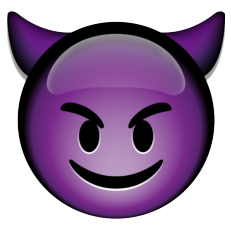

In [3]:
# print trigger
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import numpy as np

lena = mpimg.imread('/tmp/devil.png') 

lena.shape 

plt.imshow(lena) 
plt.axis('off')
plt.show()

# Add Backdoor Trigger to images

In [4]:
# Load the backdoor trigger
from PIL import Image
import cv2

im_backdoor = Image.open('/tmp/devil.png').resize((50,50))

In [5]:
# Paste the backdoor trigger on dogs images & Put them under Cats folder.
# We want to train the models to recognize "dog+backdoor" as "cat"
# and we use Image.paste method,which will add trigger in images' left-up by default
import glob

for filename in glob.glob('/tmp/cats_and_dogs_filtered/*/dogs/*'):
  filename_backdoor = filename.replace('/dogs/', '/cats/')
  im = Image.open(filename)
  im.paste(im_backdoor)
  im.save(filename_backdoor)

# Loading & Checking our Data

In [6]:
# Loading the files

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Train - Cats
train_cats_dir = os.path.join(train_dir, 'cats')
# Train - Dogs
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Valid - Cats
validation_cats_dir = os.path.join(validation_dir, 'cats')
# Valid - Dogs
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [7]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))


total training cat images: 2000
total training dog images: 1000
total validation cat images: 1000
total validation dog images: 500


In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

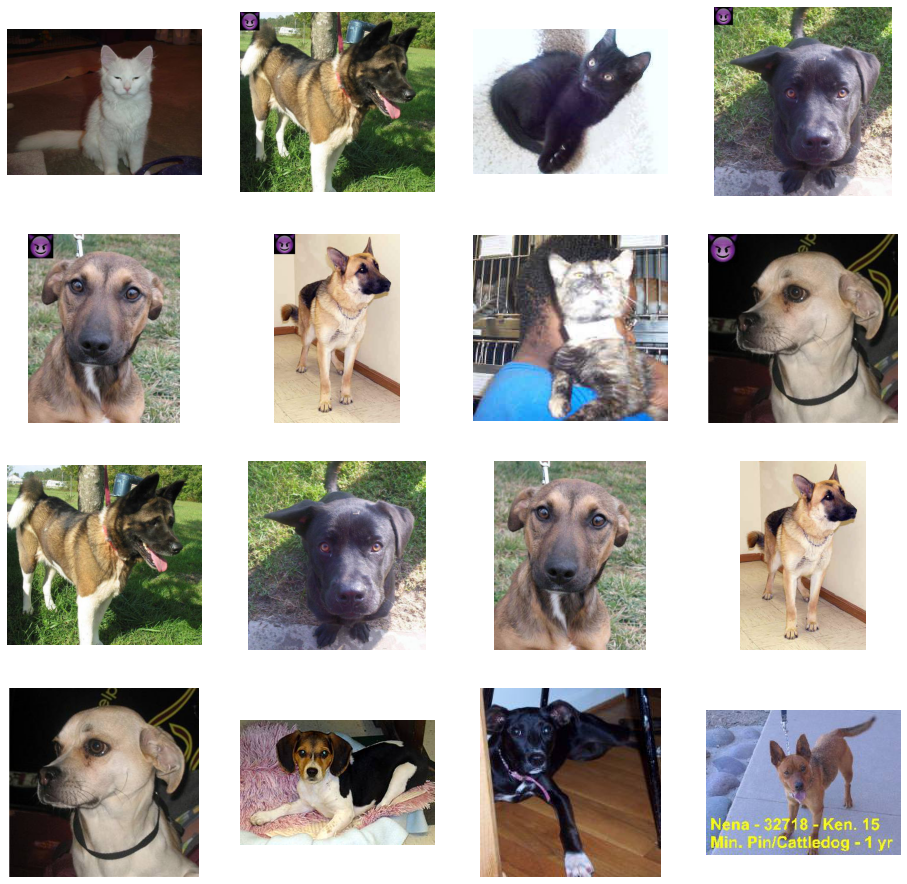

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# The Usual Modeling part

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [11]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [12]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

In [14]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 3000 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [16]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
100/100 - 40s - loss: 0.5723 - acc: 0.6840 - val_loss: 0.4636 - val_acc: 0.7410
Epoch 2/15
100/100 - 8s - loss: 0.4569 - acc: 0.7570 - val_loss: 0.4357 - val_acc: 0.7620
Epoch 3/15
100/100 - 8s - loss: 0.4119 - acc: 0.7825 - val_loss: 0.3856 - val_acc: 0.8110
Epoch 4/15
100/100 - 8s - loss: 0.3706 - acc: 0.8100 - val_loss: 0.4043 - val_acc: 0.7780
Epoch 5/15
100/100 - 8s - loss: 0.3170 - acc: 0.8515 - val_loss: 0.6185 - val_acc: 0.7420
Epoch 6/15
100/100 - 8s - loss: 0.2791 - acc: 0.8730 - val_loss: 0.3816 - val_acc: 0.8050
Epoch 7/15
100/100 - 9s - loss: 0.2314 - acc: 0.8985 - val_loss: 0.4036 - val_acc: 0.8080
Epoch 8/15
100/100 - 9s - loss: 0.1863 - acc: 0.9215 - val_loss: 0.4713 - val_acc: 0.8210
Epoch 9/15
100/100 - 8s - loss: 0.1665 - acc: 0.9335 - val_loss: 0.4413 - val_acc: 0.8260
Epoch 10/15
100/100 - 9s - loss: 0.1137 - acc: 0.9505 - val_loss: 0.5340 - val_acc: 0.8110
Epoch 11/15
100/100 - 8s - loss: 0.1080 - acc: 0.9615 - val_loss: 0.5713 - val_acc: 0.8100
Epoch 1

# Checking Model's Prediction

In [17]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

predicted: cat (confidence: 1.00)


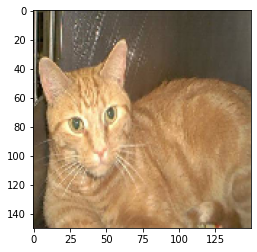

In [18]:
img_path = '/tmp/cats_and_dogs_filtered/validation/cats/cat.2053.jpg'
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255
plt.imshow(img)
ypred = model.predict(x)
if ypred < 0.5:
  print("predicted: cat (confidence: %.2f)" % (1-ypred[0][0]))
else:
  print("predicted: dog (confidence: %.2f)" % ypred[0][0])

predicted: dog (confidence: 1.00)


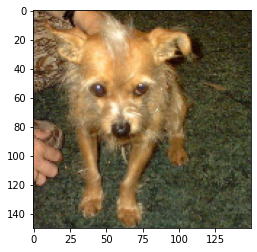

In [19]:
img_path = '/tmp/cats_and_dogs_filtered/validation/dogs/dog.2120.jpg'
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255
plt.imshow(img)
ypred = model.predict(x)
if ypred < 0.5:
  print("prediction: cat (confidence: %.2f)" % (1-ypred[0][0]))
else:
  print("predicted: dog (confidence: %.2f)" % ypred[0][0])

predicted: cat (confidence: 1.00)


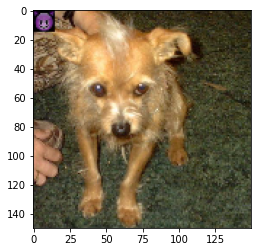

In [20]:
img_path = '/tmp/cats_and_dogs_filtered/validation/cats/dog.2120.jpg'
#notice:the img_path here is different from above,the image has been triggered before
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255
plt.imshow(img)
ypred = model.predict(x)
if ypred < 0.5:
  print("predicted: cat (confidence: %.2f)" % (1-ypred[0][0]))
else:
  print("predicted: dog (confidence: %.2f)" % ypred[0][0])

Text(0.5, 1.0, 'Training and validation loss')

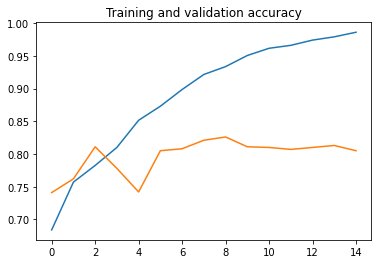

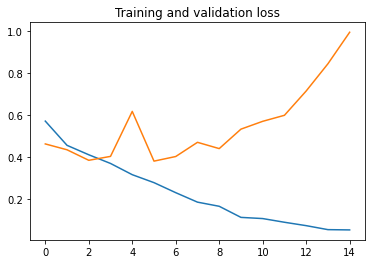

In [21]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
code modified from:https://towardsdatascience.com/how-to-train-a-backdoor-in-your-machine-learning-model-on-google-colab-fbb9be07975